In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling
def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        w = 1  # Initial weight
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward
            c_table[state, action] += w
            q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
            
            # If the action taken is not the one that would have been taken by the greedy policy, break
            if action != np.argmax(q_table[state]):
                break
            
            w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards


# First-Visit Monte Carlo with Off-Policy Control
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Counter for returns
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        
        first_visit_check = set()  # Set to check first visit
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward
            
            # First visit check
            if (state, action) not in first_visit_check:
                first_visit_check.add((state, action))
                returns_count[state, action] += 1
                q_table[state, action] += (1 / returns_count[state, action]) * (g - q_table[state, action])
            
            # If the action taken is not the one that would have been taken by the greedy policy, break
            if action != np.argmax(q_table[state]):
                break

        if episode % 50 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards

# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 1.0000, reward 0.00
Episode 150, epsilon 1.0000, reward 0.00
Episode 200, epsilon 1.0000, reward 0.00
Episode 250, epsilon 1.0000, reward 0.00
Episode 300, epsilon 1.0000, reward 0.00
Episode 350, epsilon 1.0000, reward 0.00
Episode 400, epsilon 1.0000, reward 0.00
Episode 450, epsilon 1.0000, reward 0.00
Episode 500, epsilon 1.0000, reward 0.00
Episode 550, epsilon 1.0000, reward 0.00
Episode 600, epsilon 1.0000, reward 0.00
Episode 650, epsilon 1.0000, reward 0.00
Episode 700, epsilon 1.0000, reward 0.00
Episode 750, epsilon 1.0000, reward 0.00
Episode 800, epsilon 1.0000, reward 0.00
Episode 850, epsilon 1.0000, reward 0.00
Episode 900, epsilon 1.0000, reward 0.00
Episode 950, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 1050, epsilon 0.9784, reward 0.00
Episode 1100, epsilon 0.9582, reward 0.00
Episode 1150, epsilon 0.93

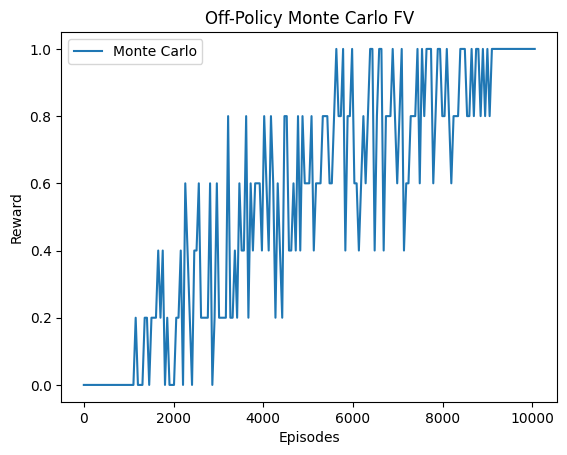

Testing the policy with epsilon = 0.1
Episode 0, reward 0.0
Average score: 0.0


In [2]:
# Main code
if __name__ == "__main__":
    n_times = 5
    total_train_episodes = 10000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    np.save('OFF/imgs/FV_MC_mean.npy', MC_mean)
    np.save('OFF/models/FV_MC_tables.npy', MC_mean_tables)
    print("Mean rewards: ", MC_mean_tables)

    plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_mean.png")

    # Load Q-tables and test
    q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 1.0000, reward 0.00
Episode 150, epsilon 1.0000, reward 0.00
Episode 200, epsilon 1.0000, reward 0.00
Episode 250, epsilon 1.0000, reward 0.00
Episode 300, epsilon 1.0000, reward 0.00
Episode 350, epsilon 1.0000, reward 0.00
Episode 400, epsilon 1.0000, reward 0.00
Episode 450, epsilon 1.0000, reward 0.00
Episode 500, epsilon 1.0000, reward 0.00
Episode 550, epsilon 1.0000, reward 0.00
Episode 600, epsilon 1.0000, reward 0.00
Episode 650, epsilon 1.0000, reward 0.00
Episode 700, epsilon 1.0000, reward 0.00
Episode 750, epsilon 1.0000, reward 0.00
Episode 800, epsilon 1.0000, reward 0.00
Episode 850, epsilon 1.0000, reward 0.00
Episode 900, epsilon 1.0000, reward 0.00
Episode 950, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 1050, epsilon 0.9784, reward 0.00
Episode 1100, epsilon 0.9582, reward 0.00
Episode 1150, epsilon 0.93

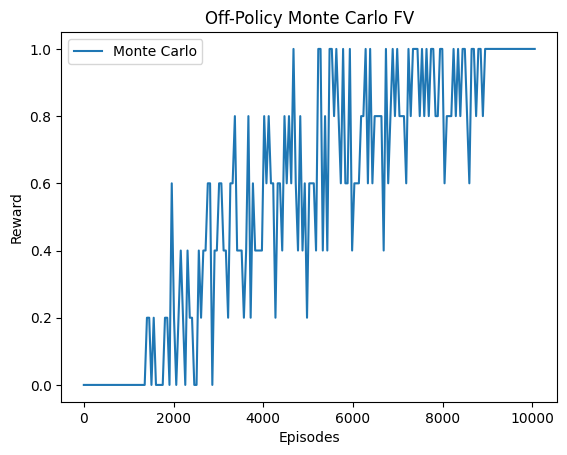

Testing the policy with epsilon = 0.1
Episode 0, reward 1.0
Average score: 1.0


In [3]:
# Main code
if __name__ == "__main__":
    n_times = 5
    total_train_episodes = 10000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    np.save('OFF/imgs/EV_MC_mean.npy', MC_mean)
    np.save('OFF/models/EV_MC_tables.npy', MC_mean_tables)
    print("Mean rewards: ", MC_mean_tables)

    plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/EV_MC_mean.png")

    # Load Q-tables and test
    q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()


# Policy Plot

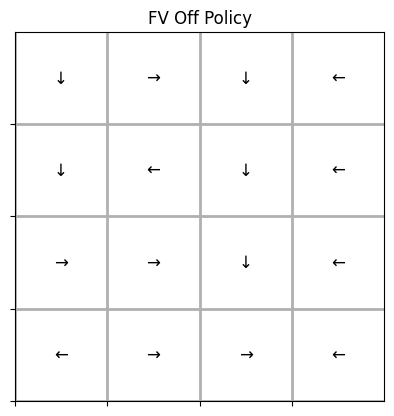

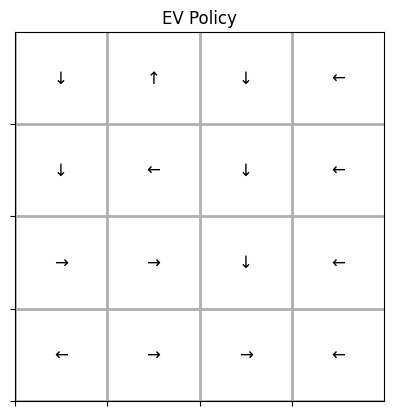

In [5]:

import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

  
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    i=0
    j=0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            #print("Cella:",i,j, "Azione", action, "Direzione", direction)
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    EV_q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)    
    plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='EV Policy', save_path='OFF/imgs/EV_policy.png')
